In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Segmentation model Package

In [2]:
!pip install keras_unet_collection

     |████████████████████████████████| 67 kB 2.6 MB/s 


Import Package and Print package version and GPU

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras_unet_collection import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow 2.8.0; Keras 2.8.0
Num GPUs Available:  []


Define Function 

In [4]:
def show(img_,text):
    print(text,img_.shape,np.amin(img_),np.amax(img_))
    # plt.figure(figsize=(8,8))
    plt.imshow(img_)
    plt.title(text,fontsize=20)
    plt.xlabel(str(img_.shape))
    plt.ylabel(str(np.amin(img_))+' ~ '+str(np.amax(img_)))
    return

In [5]:
!unzip "/content/drive/MyDrive/醫學影像標註工作坊/predict.zip"

Archive:  /content/drive/MyDrive/醫學影像標註工作坊/predict.zip
  inflating: predict/CVAI-0029_RCA_LAO62_CRA2_34_image.png  
  inflating: predict/CVAI-0213_LCX_LAO51_CRA23_34_image.png  
  inflating: predict/CVAI-0294_LCX_LAO45_CRA15_37_image.png  
  inflating: predict/CVAI-0338_RCA_LAO88_CRA0_23_image.png  
  inflating: predict/CVAI-0501_LAD_RAO11_CRA29_57_image.png  


raw image (512, 512, 3) 74 184



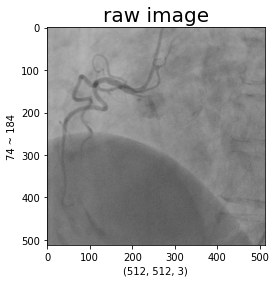

In [6]:
import glob
file_name = glob.glob("/content/predict/*.png")
raw_imgage = [cv2.imread(file) for file in file_name]
raw_imgage = np.array(raw_imgage)
show(raw_imgage[0],'raw image')
print()

Read Raw Image and show

In [7]:
IMG_HEIGHT = raw_imgage[0].shape[0]
IMG_WIDTH  = raw_imgage[0].shape[1]
IMG_CHANNELS = raw_imgage[0].shape[2]
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
num_labels = 1  #Binary
for i in range(0,len(raw_imgage)):
  raw_imgage[i] = cv2.resize(raw_imgage[i], (512, 512), interpolation=cv2.INTER_CUBIC)
  raw_imgage[i] = raw_imgage[i].reshape([1] + [512, 512, 3])

Define Segmentation Model and load model weight

In [8]:
model = models.unet_2d(input_shape, filter_num=[64, 128, 256, 512, 1024],
                           n_labels=num_labels,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           output_activation='Sigmoid',
                           batch_norm=True, pool='max', unpool='nearest',
                           backbone='ResNet50', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='unet')
model.load_weights('/content/drive/MyDrive/醫學影像標註工作坊/segmentation_model_weight.hdf5')

94781440/94765736 [==============================] - 1s 0us/step


Segmentation Prediction 

In [9]:
pred = model.predict(raw_imgage)

Show model prediction and raw image

raw (512, 512, 3) 16 203
pred (512, 512) 0.0071145296 1.0


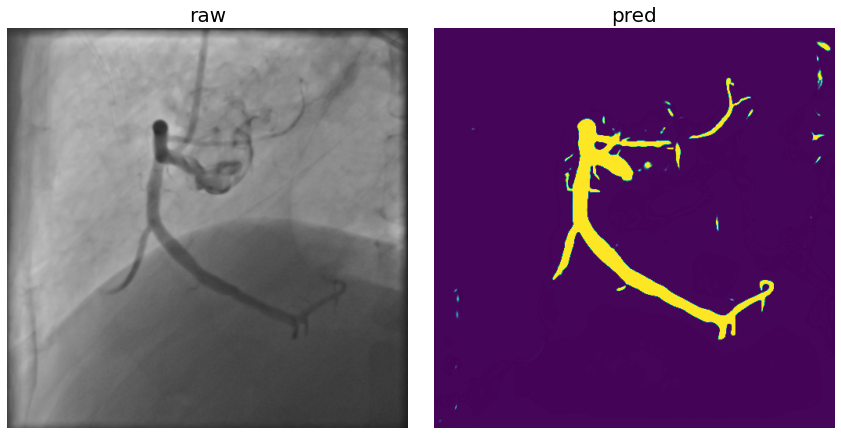

In [10]:
plt.figure(figsize=(12,6))
#aaa = raw_imgage[1]
# raw_imgage2 = np.squeeze(raw_imgage[1],0)
pred2 = np.squeeze(pred)
plt.subplot(1,2,1)
show(raw_imgage[0],'raw')
# plt.imshow(raw_imgage2)
plt.axis('off')
plt.subplot(1,2,2)
show(pred2[0],'pred')
# plt.imshow(pred2)
plt.axis('off')
plt.tight_layout()


Save Model Predictino to PNG

pred_RGB (512, 3) 3 7
pred_RGB (512, 3) 3 97
pred_RGB (512, 3) 3 9
pred_RGB (512, 3) 3 7
pred_RGB (512, 3) 3 9


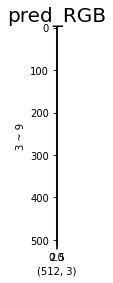

In [11]:
#print(pred2.dtype)
!mkdir output
for i in range(0,len(pred2)):
  pred3 = pred2[i]
  pred3 = cv2.cvtColor(pred3,cv2.COLOR_GRAY2RGB)
  pred3 = pred3*255 #0~1 -> 0~255
  pred3 = pred3.astype(np.uint8)
  #print(pred3.dtype)
  show(pred3[0],'pred_RGB')
  cv2.imwrite("output/"+file_name[i].split('.')[0].split('/')[-1]+"_output.png",pred3)

In [12]:
!zip -r "/content/output.zip" "/content/output"

  adding: content/output/ (stored 0%)
  adding: content/output/CVAI-0338_RCA_LAO88_CRA0_23_image_output.png (deflated 16%)
  adding: content/output/CVAI-0294_LCX_LAO45_CRA15_37_image_output.png (deflated 17%)
  adding: content/output/CVAI-0213_LCX_LAO51_CRA23_34_image_output.png (deflated 17%)
  adding: content/output/CVAI-0501_LAD_RAO11_CRA29_57_image_output.png (deflated 16%)
  adding: content/output/CVAI-0029_RCA_LAO62_CRA2_34_image_output.png (deflated 16%)


In [13]:
!cp /content/output.zip /content/drive/MyDrive/醫學影像標註工作坊